# Machine Learning in Energy Markets

# Notebook 1 - Data Preparation and Exploration

In this study, some example machine learning techniques are used to better understand European energy market data, leading to predictive modelling, making forecasts. After examining and visualising artefacts of the data, predictive analytics is performed to answer some key questions that will assist decision-makers within the field to develop data- and fact-driver strategies.

The study is broken down into two parts (and so two notebooks).

** Notebook 1 - Data Preparation and Data Exploration **

* [**Section 1: Data preparation**](#section1)
    * [Obtaining and preparing the data](#section1.1)
    * [Cleaning the data and preprocessing for data analysis](#section1.2)
    * [Converting to daily data](#section1.3)
    

* [**Section 2: data exploration**](#section2)
    * [Analysis of moments](#section2.1)
    * [Volatility breakdown](#section2.2)
    * [Seasonal decomposition](#section2.3)

** Notebook 2 - Predictive Analytics **

Notebook two procedes with the analysed and selected subsets of data to make predictions.

<a id='section1'></a>
##  Section 1: Data Preparation

The transparent energy platforms, named [**entso-g**](https://www.entsog.eu/) and [**entso-e**](https://www.entsoe.eu/Pages/default.aspx)  for gas and electricity respectively, provide high frequency data across a variety of energy types, spread across over 30 countries. The entire sqlite database is downloaded and prepared for access.

The data is collected and provided free of charge in convenient formats from the project run at [Open Power System Data](http://open-power-system-data.org/ "visit website"). We will use the `sqlite` database they provide as a source to extract data into Pandas DataFrames - the [latest version of the database can be found here](https://data.open-power-system-data.org/time_series/latest/). This is then easily combined with other financial market data etc.
Other data formats are freely available for download.

<a id='section1.1'></a>
### Obtaining and preparing the data

In [37]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

## load basic libraries
import pandas as pd
import sqlite3
import requests
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## load non-basic libraries - may need to be installed via pip/conda

# used to visualise missing data i.e. null-values in the dataset
import missingno as msno

# used to visualise time-series as a heatmap
import calmap


## Jupyter setup

# set default size figures
plt.rcParams['figure.figsize'] = (18, 12)

# force plots to be rendered automatically once created
%matplotlib inline

# in order to use R within a Python based notebook (need to install `rpy2` using pip/conda)
#%load_ext rpy2.ipython

In [2]:
def download_file(url, target=None):
    """Download a file by providing the download link URL.
    Checks if file already exists to prevent downloading twice.
    
    url: the download URL for the file
    target: must be a string to the location to save the file.
            If not given, file is downloaded into current working directory, its name taken from the URL.
    """
    if target:
        local_filename = target
    else:
        local_filename = url.split('/')[-1]
        
    if os.path.exists(local_filename):
        print('The file already exists! The path is: {}'.format(local_filename))
        return local_filename
    else:
        r = requests.get(url, stream=True)
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    
    return local_filename

###### Download the file, if not already in working directory

In [3]:
SQL_FILE = download_file('http://data.open-power-system-data.org/time_series/2017-03-06/time_series.sqlite',
                         target='./time_series.sqlite')

The file already exists! The path is: ./time_series.sqlite


###### Inspect the database
The connection is tested and also the names of all of the columns in the selected table are read and counted. This approach will allow for checking column entries are valid later on when selecting subsets of data.

In [4]:
freqs = [15, 60]
db_info = {}

with sqlite3.connect(SQL_FILE) as conn:
    for freq in freqs:
        cursor = conn.execute('select * from time_series_' + str(freq) + 'min_singleindex')
        n_cols = len(cursor.description)
        db_info['col_names' + str(freq)] = [i[0] for i in cursor.description]
        print("Number of variables in {}-minute data: {}".format(freq, n_cols))

print('\nColumn names are stored in the db_info dictionary')

Number of variables in 15-minute data: 41
Number of variables in 60-minute data: 95

Column names are stored in the db_info dictionary


###### Variable notation

There are many variables available in the dataset. They are broken down by type of enery, then into categories like generation, profile, load, capacity etc.
Here is an table taken from the [Open Power System Platform](https://nbviewer.jupyter.org/github/Open-Power-System-Data/datapackage_timeseries/blob/2017-03-06/main.ipynb "Visit webpage"), which breaks down the naming conventions for the variables:

<img src="variable_notation.png",width=1000,height=1>

Several examples of variable names:

* `DE_solar_generation`
* `DE_transnetbw_wind_forecast`
* `GB_load_`


###### Define two separate functions to extract data from the sqlite database
 - one to get everything for a given frequency and start date
 - one to select specific columns for a given frequency.

In [5]:
def get_all_data(sqlite_file, freq=60,
                 start="2000-01-01T00:00:00+0100",
                 end="2018-01-01T00:00:00+0100"):
    """
    sqlite_data: Specify the location of the `.sqlite` file
    FREQ: Provide a frequency of either 15-minute or 60-minute frequency data. Default is 60-minute frequency
    start: the beginning of the time-series data to extract from the DB. Default is the entire time-series
    
    returns: a Pandas DataFrame with the raw data, including all available columns, integer-indexed.
    """
    
    # check that a correct frequency is provided
    assert (freq in (15, 60)), 'The "FREQ" value must be either 15 or 60 for minute-frequency of the time-series data\n'
    'You entered: {}'.format(freq)
   
    print('Extracting selected columns... \n\nfrom: {}\nto:   {}\nfreq: {}-minute'.format(start, end, freq))
       
    with sqlite3.connect(sqlite_file) as conn:
        select_statement = ('select * from time_series_{}min_singleindex '
                            'where cet_cest_timestamp > "{}" and cet_cest_timestamp < "{}"').format(freq, start, end)
        all_data = pd.read_sql(select_statement, conn)
        print('\nFinished!')
        
    return all_data

In [6]:
def get_cols_data(sqlite_file, cols=['DE_wind_generation'], freq=60,
                  start="2000-01-01T00:00:00+0100",
                  end="2018-01-01T00:00:00+0100"):
    """
    sqlite_data: Specify the location of the `.sqlite` file
    cols: a list of column names (as strings) to be used in the _select_ statement. A date column is included by default
    FREQ: Provide a frequency of either 15-minute or 60-minute frequency data. Default is 60-minute frequency
    start: the beginning of the time-series data to extract from the DB. Default is the entire time-series
    
    returns: a Pandas DataFrame with the raw data, including all columns passed in argument `cols`.
             The returned DataFrame is integer-indexed.
    """
    
    # check that a correct frequency is provided
    assert (freq in (15, 60)), 'The "FREQ" value must be either 15 or 60 for minute-frequency of the time-series data\n'
    'You entered: {}'.format(freq)

    # check that all the desired columns exist in the specified frequency table - use lengths...
    with sqlite3.connect(SQL_FILE) as conn:    
        cursor = conn.execute('select * from time_series_' + str(freq) + 'min_singleindex')
        #ncols = len(cursor.description)
        colnames = [i[0] for i in cursor.description]
    
    # Check that all selected columns are actually available
    select_length = len(cols)
    matching_cols = sum([col in colnames for col in cols])
    assert (select_length == matching_cols), 'Not all the desired columns exist in the target table'
    
    print('Extracting selected columns... \n\nfrom: {}\nto:   {}\nfreq: {}-minute'.format(start, end, freq))
            
    # construct print statement
    cols_as_str = ', '.join(['cet_cest_timestamp'] + cols)
    select_statement = ('select {} from time_series_{}min_singleindex '
                        'where cet_cest_timestamp > "{}" and cet_cest_timestamp < "{}"').format(cols_as_str, freq, start, end)
    # extract the data
    data = pd.read_sql(select_statement, conn)
    print('\nFinished!')
        
    return data

###### Test out function extracting all columns

In [7]:
all_data = get_all_data('./time_series.sqlite', freq=60,
                        start="2015-01-01T00:00:00+0100",
                        end="2016-01-01T00:00:00+0100")

print('\nDimensions of table: {}\n'.format(all_data.shape))
all_data.iloc[[0, 1, 2, -3, -2, -1]]

Extracting selected columns... 

from: 2015-01-01T00:00:00+0100
to:   2016-01-01T00:00:00+0100
freq: 60-minute

Finished!

Dimensions of table: (8759, 95)



,utc_timestamp,cet_cest_timestamp,AT_load_,BA_load_,BE_load_,BG_load_,CH_load_,CS_load_,CY_load_,CZ_load_,...,SE_load_,SE_price_day_ahead,SE_solar_generation,SE_wind_generation,SE_3_price_day_ahead,SE_4_price_day_ahead,SI_load_,SK_load_,UA_west_load_,interpolated_values
0,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,6908.0,1519.0,9094.0,5024.0,7643.0,None,395.0,6064.0,...,14845.0,None,0.0,3415.0,23.0,23.0,1194.0,2860.0,718.0,None
1,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,6601.0,1423.0,8691.0,4773.0,7394.0,None,361.0,5958.0,...,14554.0,None,0.0,3443.0,19.0,19.0,1153.0,2728.0,691.0,None
2,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,6311.0,1367.0,8354.0,4585.0,7335.0,None,333.0,5879.0,...,14267.0,None,0.0,3333.0,18.0,18.0,1113.0,2626.0,689.0,None
8756,2015-12-31T20:00:00Z,2015-12-31T21:00:00+0100,7223.0,1680.0,8682.0,5273.0,6868.0,None,566.0,6329.0,...,16973.0,None,0.0,2868.0,16.0,16.0,1399.0,2997.0,846.0,None
8757,2015-12-31T21:00:00Z,2015-12-31T22:00:00+0100,7424.0,1606.0,9045.0,5161.0,6906.0,None,540.0,6171.0,...,16469.0,None,0.0,2599.0,16.0,16.0,1335.0,2971.0,784.0,None
8758,2015-12-31T22:00:00Z,2015-12-31T23:00:00+0100,7094.0,1537.0,9176.0,5105.0,6897.0,None,538.0,6040.0,...,16064.0,None,0.0,2410.0,16.0,16.0,1255.0,2934.0,746.0,None


###### Test function that extracts only selected columns

In [8]:
selected_columns = ['DE_price_day_ahead', 'DE_load_']    # arbitrarily selected

some_cols = get_cols_data('./time_series.sqlite', freq=60, cols=selected_columns,
                          start="2015-01-01T00:00:00+0100",
                          end=  "2016-01-01T00:00:00+0100")

some_cols.iloc[[0,1,2,-3,-2,-1]]

Extracting selected columns... 

from: 2015-01-01T00:00:00+0100
to:   2016-01-01T00:00:00+0100
freq: 60-minute

Finished!


,cet_cest_timestamp,DE_price_day_ahead,DE_load_
0,2015-01-01T01:00:00+0100,18.0,44277.0
1,2015-01-01T02:00:00+0100,16.0,42686.0
2,2015-01-01T03:00:00+0100,15.0,41327.0
8756,2015-12-31T21:00:00+0100,26.0,47253.0
8757,2015-12-31T22:00:00+0100,30.0,47057.0
8758,2015-12-31T23:00:00+0100,32.0,45305.0


<a id='section1.2'></a>
###  Cleaning the data and preprocessing for data analysis

As the name of the section suggests, the data must still be further prepared in order to be explored and used for predictive analytics. Here we do things like remove missing values from the times-series and perform any aggregations of normalisation steps. Depending on the quality of the input data, this is a section that could rapidly become very long. Luckily, the energy market data used here is relatively well maintained.

For the rest of this work we shall use the 15-minute frequency data. Which columns from that dataset shall be used, is explained in more detail further on.

###### We first specify some intermediate parameters to define which data from the database we will use.

In [9]:
# location of the sqlite file itself
SQL_FILE = './time_series.sqlite'

# 15-minute or 60-minute data
FREQ = 60

# Provide a start/end - this take all of 2015.
START = '2015-01-01T00:00:00+0100'
END = '2015-12-31T23:00:00+0100'

In [10]:
# Extract the desired data (all the columns)
d = get_all_data(SQL_FILE, freq=FREQ, start=START, end=END)

Extracting selected columns... 

from: 2015-01-01T00:00:00+0100
to:   2015-12-31T23:00:00+0100
freq: 60-minute

Finished!


In [11]:
# create, apply and rename the date column as index for convenience
new_index = pd.to_datetime(d.cet_cest_timestamp, infer_datetime_format=True) #format='%Y-%m-d%T%H:%M:%S%z')
d.index = new_index
d.index.name = 'timestamp'

# remove the two date columns that are still there as text (no longer required)
d.drop(['utc_timestamp', 'cet_cest_timestamp'], inplace=True, axis=1, errors='ignore')

In [12]:
# Have a look to see which of the variables are missing the least data

def percentage_missing(data, reverse=True, verbose=True):
    """Computes the percentage of missing values per variable, prints it to standard out.
    data: a pandas DataFrame
    reverse: if True returns the list in descending missing percentages
    verbose: if True summary information is printed to console
    
    returns: a list of tuples, each containing the variable name and its percentage of missing values.
    """ 
    # get start and end times for the selected time-series
    data.START = d.index[0]
    data.END = d.index[-1]
    
    # compute the missing percentages
    _pc = data.isnull().sum() / len(d) * 100
    
    if verbose:
        print('Time-series begin:   {}'.format(d.START))
        print('Time-series end:     {}'.format(d.END))
        print('Data requency:       {}'.format(FREQ))
        print('Possible data-points {}'.format(len(data)))
        print('Percentage of missing points for each variable: \n\n{}'.format(_pc))
    
    _missing = [(variable, missing) for variable, missing in _pc.iteritems()]
    
    # sort the results by percentage missing
    _sorted = sorted(_missing, key=lambda x: x[1], reverse=reverse)
    
    return _sorted

In [13]:
# compute the percentage of missing data for each variable
missing = percentage_missing(d, reverse=True, verbose=False)


# Have a look at the results
pd.DataFrame(missing, columns=['Variable', 'Percentage Missing']).head(18)
#_ = [print('{}: {:.2f}%'.format(var, val)) for var, val in missing]

,Variable,Percentage Missing
0,CS_load_,100.000000
1,DE_wind_offshore_generation,100.000000
2,DE_wind_offshore_profile,100.000000
3,DE_wind_onshore_generation,100.000000
4,DE_wind_onshore_profile,100.000000
5,DE_50hertz_wind_offshore_forecast,100.000000
6,DE_50hertz_wind_offshore_generation,100.000000
7,DE_50hertz_wind_onshore_forecast,100.000000
8,DE_50hertz_wind_onshore_generation,100.000000
9,DK_west_load_,100.000000


We can see that there are many variables with no data points missing, and several with almost 100% missing. This means we cannot use all columns over the selected time range as there are too many gaps in the data set.
We will use the variables that have only a small amount of data missing, imputing (filling in) the missing values. Variables that contain less than 3% missing variables are selected below.

**Note**: if a different time-range had been selected, there would have been different results from this analysis. We appear to be losing a lot of `wind` variables here, so if wind is a desired variable for further modelling, a different time-range should be considered.

In [14]:
# a list to store the columns within a certain threshold of missing values
keep_cols = []

# set a percentage threshold for missing values within a variable.
threshold = 3.00

# iterate through the pairs, keeping only those matching our threshold
for pair in missing:
    if pair[1] < threshold:
        keep_cols.append(pair[0])

print('\nKeeping the following {} out of {} variables:\n\n{}'.format(len(keep_cols), d.shape[1], keep_cols))


Keeping the following 79 out of 93 variables:

['GR_load_', 'DE_transnetbw_solar_forecast', 'DE_transnetbw_wind_forecast', 'AT_load_', 'BA_load_', 'BE_load_', 'BG_load_', 'CH_load_', 'CY_load_', 'CZ_load_', 'CZ_solar_generation', 'CZ_wind_generation', 'DE_load_', 'DE_price_day_ahead', 'DE_solar_capacity', 'DE_solar_generation', 'DE_solar_profile', 'DE_wind_capacity', 'DE_wind_generation', 'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_onshore_capacity', 'DE_50hertz_solar_forecast', 'DE_50hertz_solar_generation', 'DE_50hertz_wind_forecast', 'DE_50hertz_wind_generation', 'DE_amprion_solar_forecast', 'DE_amprion_solar_generation', 'DE_amprion_wind_forecast', 'DE_amprion_wind_generation', 'DE_amprion_wind_onshore_generation', 'DE_tennet_solar_forecast', 'DE_tennet_solar_generation', 'DE_tennet_wind_forecast', 'DE_tennet_wind_generation', 'DE_tennet_wind_offshore_generation', 'DE_tennet_wind_onshore_generation', 'DE_transnetbw_solar_generation', 'DE_transnetbw_wind_generation', '

In [15]:
# create a new dataset using only the columns listed above
d1 = d.loc[:,keep_cols]

Another interesting aspect of the dataset is the number of zeros for each of the variables. As is shown below, the percentage is very high (~40%) for quite a few of the variables. Looking at the names, it seems they all relate to solar energy. This makes sense, as the sun isn't visible in Europe for roughly half the day.

Below we show the variables sorted in descending order by the percentage of their values that are zeros. We can see that all those variables with >40% zeros are solar energy variables.

In [16]:
# count how many zeros there are in each variable
x = (d1 == 0)
perc = (x.sum() / len(x) * 100).round(2)
x1 = pd.DataFrame(perc, columns=['percentage'])
x1.sort_values('percentage', ascending=False).head(18)

,percentage
SE_solar_generation,61.51
DK_east_solar_generation,50.13
DK_west_solar_generation,48.70
DE_transnetbw_solar_generation,46.60
DE_amprion_solar_generation,45.28
DE_transnetbw_solar_forecast,45.28
DE_amprion_solar_forecast,45.24
DE_50hertz_solar_forecast,44.63
DE_tennet_solar_generation,44.53
DE_50hertz_solar_generation,43.95


We will also remove all the forecasts, as they aren't really something we want to use for our own forecasts. We do not know how they were made and they should be nature be highly correlated to the actual values they are trying to predict.

**Note:** an interesting study would be to compare prediction model results to the forecasts provided here with the dataset.

In [17]:
for col in d1.columns:
    if 'forecast' in col:
        print('Dropping variable: {}'.format(col))
        d1.drop(col, 1, inplace=True)

print('\nKept following variables:\n')
for col in d1.columns:
    print(col)

Dropping variable: DE_transnetbw_solar_forecast
Dropping variable: DE_transnetbw_wind_forecast
Dropping variable: DE_50hertz_solar_forecast
Dropping variable: DE_50hertz_wind_forecast
Dropping variable: DE_amprion_solar_forecast
Dropping variable: DE_amprion_wind_forecast
Dropping variable: DE_tennet_solar_forecast
Dropping variable: DE_tennet_wind_forecast

Kept following variables:

GR_load_
AT_load_
BA_load_
BE_load_
BG_load_
CH_load_
CY_load_
CZ_load_
CZ_solar_generation
CZ_wind_generation
DE_load_
DE_price_day_ahead
DE_solar_capacity
DE_solar_generation
DE_solar_profile
DE_wind_capacity
DE_wind_generation
DE_wind_profile
DE_wind_offshore_capacity
DE_wind_onshore_capacity
DE_50hertz_solar_generation
DE_50hertz_wind_generation
DE_amprion_solar_generation
DE_amprion_wind_generation
DE_amprion_wind_onshore_generation
DE_tennet_solar_generation
DE_tennet_wind_generation
DE_tennet_wind_offshore_generation
DE_tennet_wind_onshore_generation
DE_transnetbw_solar_generation
DE_transnetbw_win

######  Missing values

Below we have a look at how many values are missing from each of the variables.
We see that variables have almost 100% of the time-series covered.

In the first plot, the y-axis value of 1.0 corresponds to a full dataset i.e. no missing data. Only the variable `GR_load_` appears to have a dip in its peak compared to the other bars.

In the second plot, the data are plotted corresponding to the timeline - a data point for each one-hour time-box. If there is missing data, a gap is left in the chart. The [sparkline](https://en.wikipedia.org/wiki/Sparkline) plotted along the right-hand-side shows up that there is actually only one point in the time-series where not all of the 71 variables contain data points.

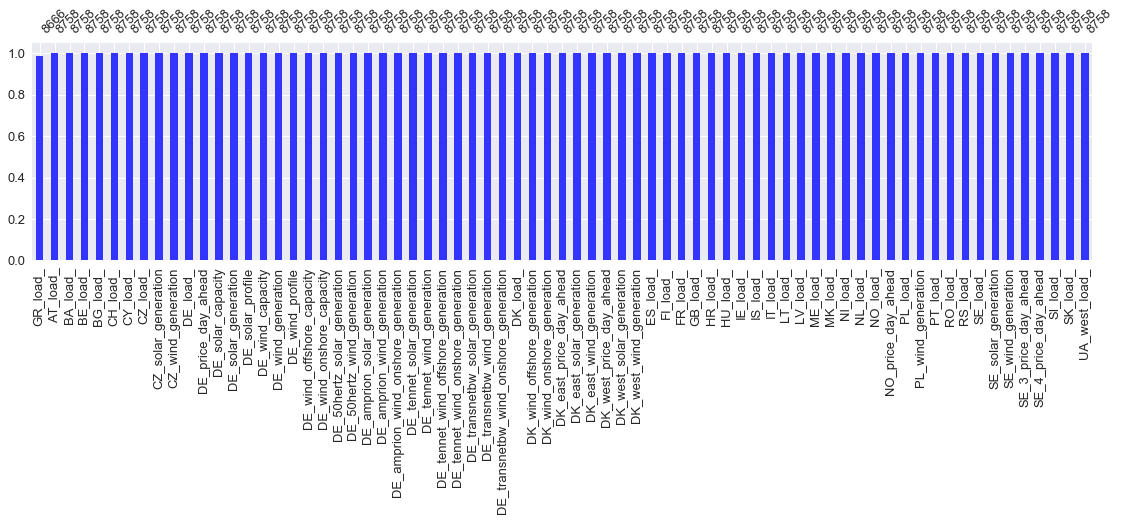

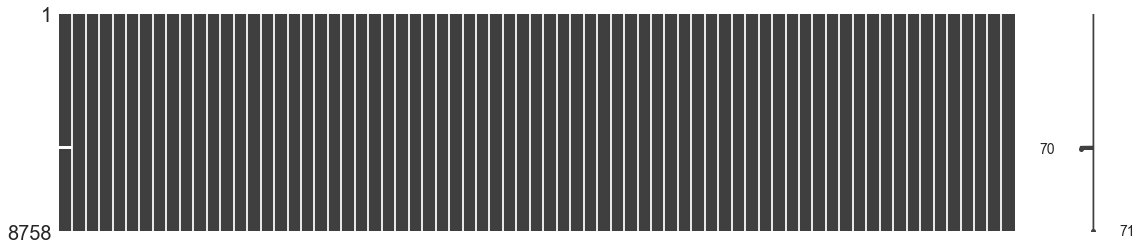

In [18]:
# Visualise the variables to show missing data
msno.bar(d1, figsize=(19, 4), fontsize=13, inline=True, color=(51/255, 52/255, 253/255))
msno.matrix(d1, figsize=(19,4), fontsize=13, inline=True)

Below we see which dates the missings values correspond to. It seems to be alternating hours over a four-day period in the middle of August.
We could either fill these missing values with something (fill-forward, average, even model them), we could drop the dates for all variables or we could just remove this variable itself.
As we have many variables covering the load from European countries, I will simply remove this Greek load variable.

In [19]:
# Check to see which dates are missing
d1.iloc[d1.isnull().any(axis=1).nonzero()[0]].index

DatetimeIndex(['2015-08-11 22:00:00', '2015-08-11 23:00:00',
               '2015-08-12 00:00:00', '2015-08-12 01:00:00',
               '2015-08-12 02:00:00', '2015-08-12 03:00:00',
               '2015-08-12 04:00:00', '2015-08-12 05:00:00',
               '2015-08-12 06:00:00', '2015-08-12 07:00:00',
               '2015-08-12 08:00:00', '2015-08-12 09:00:00',
               '2015-08-12 10:00:00', '2015-08-12 11:00:00',
               '2015-08-12 12:00:00', '2015-08-12 13:00:00',
               '2015-08-12 14:00:00', '2015-08-12 15:00:00',
               '2015-08-12 16:00:00', '2015-08-12 17:00:00',
               '2015-08-12 18:00:00', '2015-08-12 19:00:00',
               '2015-08-12 20:00:00', '2015-08-12 22:00:00',
               '2015-08-12 23:00:00', '2015-08-13 00:00:00',
               '2015-08-13 01:00:00', '2015-08-13 02:00:00',
               '2015-08-13 03:00:00', '2015-08-13 04:00:00',
               '2015-08-13 05:00:00', '2015-08-13 06:00:00',
               '2015-08-

In [20]:
# Remove the Greek load data from data set
d2 = d1.drop('GR_load_', axis=1)

###### Final dataset

We will attempt to predict the day-ahead spot price of electricity in Germany. The historical data that we have for this shall be split later on, along with the rest of the data, into training, validation and test datasets.

At this point, just before beginning modelling, it would be important to impute the data, i.e. fill in the missing any values. Although we should know from the plots of missing data above that we don't have any gaps left, the imputation step is shown for completeness.

It is important to impute datasets before modelling, as many implementations of models do no cope well with missing values. Some of them might impute or just leave out missing values. Imputing ourself allows us to control how it is done and ensure we are in the best positions possible to understand our results.

In [21]:
# see what percentage of the data is missing (None values), then impute them with fill-forward
missing_values = d2.isnull().sum()/len(d2) * 100
print("Average percentage of None values before imputing: {:.2f}%".format(missing_values.mean()))

# impute
d2.fillna(method='ffill', inplace=True)
missing_values = d2.isnull().sum()/len(d2) * 100
print("Average percentage of None values after imputing:  {:.2f}%".format(missing_values.mean()))

d2

Average percentage of None values before imputing: 0.00%
Average percentage of None values after imputing:  0.00%


,AT_load_,BA_load_,BE_load_,BG_load_,CH_load_,CY_load_,CZ_load_,CZ_solar_generation,CZ_wind_generation,DE_load_,...,RO_load_,RS_load_,SE_load_,SE_solar_generation,SE_wind_generation,SE_3_price_day_ahead,SE_4_price_day_ahead,SI_load_,SK_load_,UA_west_load_
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,6908.0,1519.0,9094.0,5024.0,7643.0,395.0,6064.0,0.0,28.0,44277.0,...,6180.0,6132.0,14845.0,0.0,3415.0,23.0,23.0,1194.0,2860.0,718.0
2015-01-01 01:00:00,6601.0,1423.0,8691.0,4773.0,7394.0,361.0,5958.0,0.0,27.0,42686.0,...,5904.0,5773.0,14554.0,0.0,3443.0,19.0,19.0,1153.0,2728.0,691.0
2015-01-01 02:00:00,6311.0,1367.0,8354.0,4585.0,7335.0,333.0,5879.0,0.0,42.0,41327.0,...,5706.0,5471.0,14267.0,0.0,3333.0,18.0,18.0,1113.0,2626.0,689.0
2015-01-01 03:00:00,6230.0,1330.0,8080.0,4440.0,7004.0,319.0,5828.0,0.0,55.0,40689.0,...,5541.0,5199.0,14224.0,0.0,3299.0,18.0,18.0,1091.0,2618.0,698.0
2015-01-01 04:00:00,6321.0,1321.0,7965.0,4418.0,7045.0,313.0,5731.0,0.0,56.0,39976.0,...,5545.0,5060.0,14370.0,0.0,3358.0,18.0,18.0,1107.0,2626.0,712.0
2015-01-01 05:00:00,6377.0,1362.0,8005.0,4393.0,6839.0,299.0,5669.0,0.0,59.0,38552.0,...,5472.0,4987.0,14780.0,0.0,3409.0,25.0,25.0,1155.0,2641.0,741.0
2015-01-01 06:00:00,6677.0,1397.0,7749.0,4441.0,6619.0,302.0,5601.0,4.0,60.0,38798.0,...,5376.0,4944.0,15098.0,0.0,3360.0,27.0,27.0,1193.0,2622.0,768.0
2015-01-01 07:00:00,7035.0,1513.0,7769.0,4637.0,6563.0,319.0,5651.0,7.0,59.0,39465.0,...,5326.0,5163.0,15231.0,0.0,3345.0,27.0,27.0,1250.0,2691.0,813.0
2015-01-01 08:00:00,7394.0,1631.0,7860.0,4834.0,6812.0,336.0,6115.0,21.0,68.0,41752.0,...,5448.0,5453.0,15453.0,0.0,3532.0,26.0,26.0,1315.0,2794.0,828.0


<a id='section1.7'></a>
### Converting to daily data (experimental)

Just as an example of another way the data could be processed, it is shown below how we might convert the hourly data into daily data. In this case, it is performed by taking the mean of the values over each individual day. This should exhibit a smoothing effect on the data and perhaps make it easier to extract larger trends over the selected time-series.

For the remainder of this study, however, we shall be working with hourly data.

In [22]:
# make a copyof our hourly data and convert it into daily frequency
x = d.copy()
f = x.groupby([lambda x: x.strftime("%d-%m-%Y")]).mean()
f.index = pd.to_datetime(f.index, infer_datetime_format=True)
f.sort_index(inplace=True)

Looking at the comparison plot below for the German day ahead price, we can see the there is a smoothing effect as one would expect, having plotted the daily averages. A second thing that becomes clear is that the majority of the deviations away from the mean appear to be above the mean. This signifies a slight upward volatility, which is visualised in a kernel density plot of the two distributions that follows.

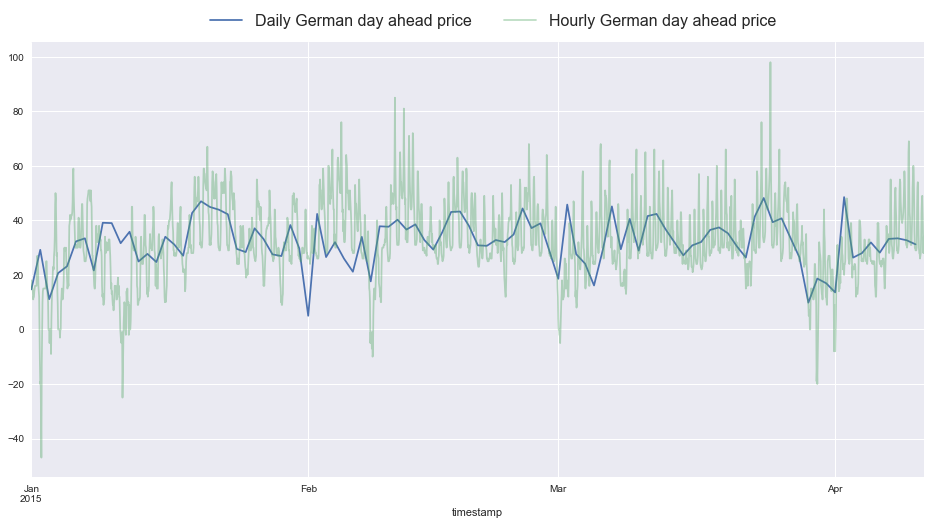

In [23]:
# plot a few of the variables from the daily and the hourly data to see the expected smoothing effect

days_to_display = 100
hours_to_display = 24 * days_to_display

hourly = d.loc[:, ['DE_price_day_ahead']].iloc[0:hours_to_display]
hourly.columns = ['Hourly German day ahead price']

daily = f.loc[:, ['DE_price_day_ahead']].iloc[0:days_to_display]
daily.columns = ['Daily German day ahead price']

ax = daily.plot(figsize=(16,8), logy=True)
_ = hourly.plot(alpha=0.4, ax=ax)

_ = ax.legend(bbox_to_anchor=[0.85, 1.1], fontsize=16, ncol=2)

##### Distribution of prices

We can see below how the distribution of the daily and the hourly prices differ. The hourly prices exhibit a _less normal_ distribution, perhaps a possibility to model the difference further using for example (Gaussian) Mixture Models or Variational Bayesian Mixture Models. One could find the various modes/components of the hourly prices and tailor a conditional forecasting model based on non-continuous temporal windows, concatenating the identified modes chronologically.

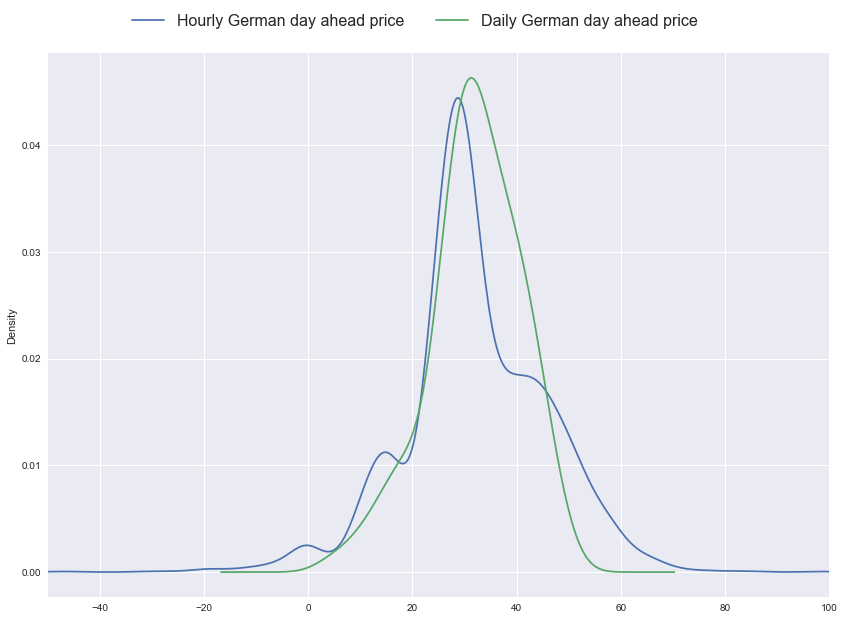

In [24]:
ax = hourly.plot(kind='kde', figsize=(14, 10), xlim=[-50, 100])
_ = daily.plot(ax=ax, kind='kde')
_ = ax.legend(bbox_to_anchor=[0.85, 1.1], fontsize=16, ncol=2)

<a id='section2'></a>
## Section 2: data exploration

### First impressions

Let us begin by having a look at the first week of the time-series, plotting all variables on a log-scale (as they all have different scales of magnitude).

While this plot is extremely messy (and a legend is left), this plot shows a few interesting features. Firstly, there are nice clear daily patters shown by the seven large _towers_ stretching up from the base of the graph.
Additionally, there seems to be a high amount of correlation in the movement of the variables moving across the top of the plot. Thirdly, there are several variables that seem to be following their own pattern, or are at the very least active on a different scale to the other variables.

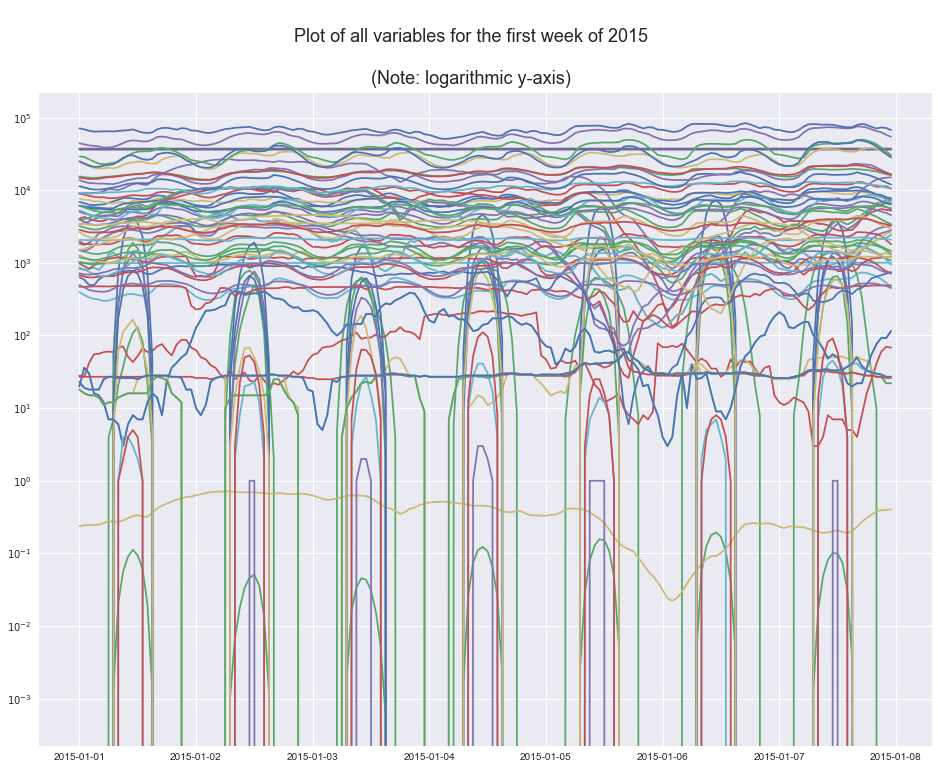

In [25]:
fig = plt.figure()
plt.plot(d2.iloc[0:(7*24)])
plt.yscale('log')
fig.set_size_inches((16, 12))
_ = fig.suptitle("\nPlot of all variables for the first week of 2015\n\n(Note: logarithmic y-axis)", fontsize=18)

###### Heatmap calendar plot

This shows the values of a variable,  a daily

Looking at our target variable (the one we shall later be trying to predict): the day-ahead price of electricity, we can spot a few more patterns. Firstly, weekends (especially Sundays) seem to contain significantly lower prices.
One could also speculate as to whether the phases of high and low prices otherwise may be contributed to seasonal changes. For example, high prices in October may be that consumers begin to use their heating after summer comes to an end, but production has not yet been ramped up by producers - additionally, the slump in renewable energy production would begin as solar energy becomes less reliable in winter months.

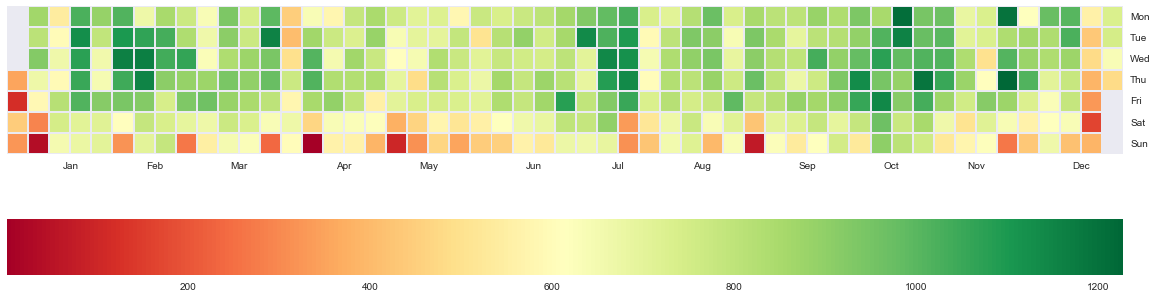

In [26]:
#fig, ax = calmap.calendarplot(d2.DE_price_day_ahead, fig_kws=dict(figsize=(19, 5)),
#                              fillcolor='grey', linewidth=0,cmap='RdYlGn')
#fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
cax = calmap.yearplot(d2.DE_price_day_ahead, year=2015, ax=ax, cmap='RdYlGn')
_ = fig.colorbar(cax.get_children()[1], ax=cax, orientation='horizontal', shrink=1)

<a id='section2.1'></a>
### Analysis of moments

Compare the moments of each of the variables over the timeline, using variable frame size.
This may characterise the behaviour of the variables in relation to each other in some intersting ways.

We select only a small set of variables tp plot, consisting of different energy types.

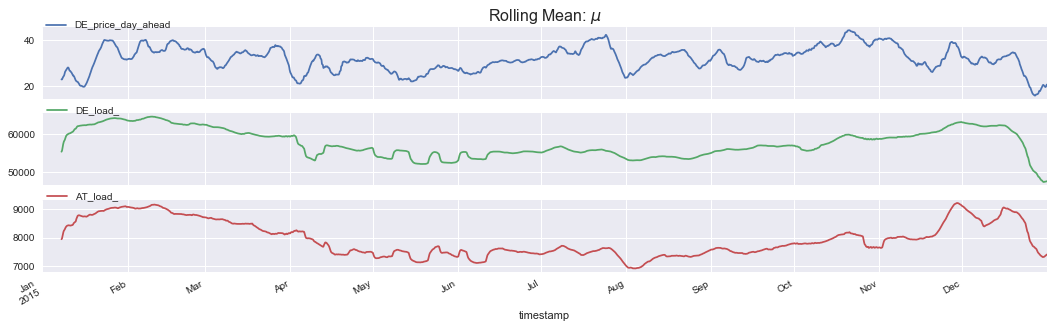

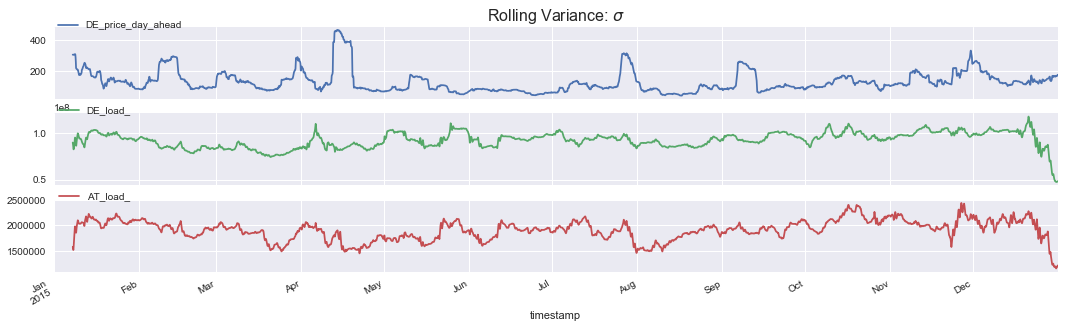

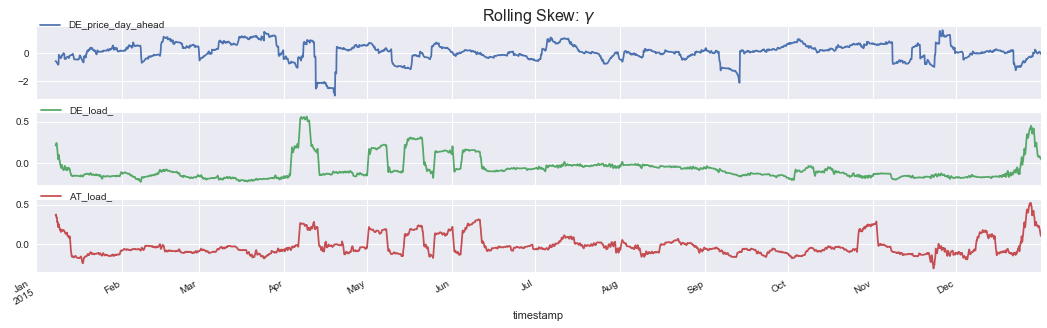

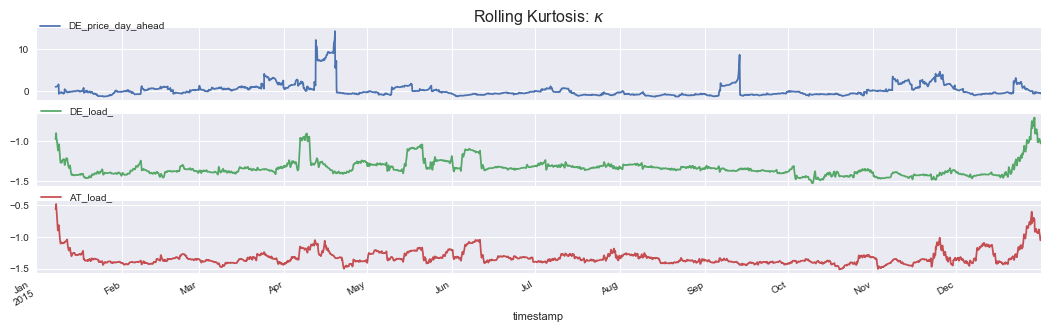

In [27]:
data_to_plot = pd.DataFrame(d2.loc[:,['DE_price_day_ahead', 'DE_load_', 'AT_load_']])


def rolling_moments(df, frame_size=40, legend_loc='center left', fig_size=(18,5),
                    mean=True, variance=True, skew=True, kurtosis=True):
    
    """Plot the moving moments, computed once for each `frame_size` days and plotted.
    By default all moments are plotted. Set individual moment _kwargs_ to False in order to not plot them.
    
    data: must be a Pandas DataFrame (see function DataFrame method `rolling` for more information)
    frame_size: the window size in days for which to compute each moment
    legend_loc: passed to the plotting function to specify where the legend should appear
    
    Returns: a tuple of `(fig, axes)` plot objects for each moment specified using the kwargs
    fig: is the figure itself for each moments (controls parameters for the first subplot)
    axes: a list of the `ax` objects for each of the subplots
    
    """
            
    assert isinstance(df, pd.core.frame.DataFrame), "The input `df` must return: type(df) = pandas.core.frame.DataFrame"
    
    # define a cache to return all (fig,ax) tuples for selected moments
    cache = {}
    
    # create facet plots for each moment, each containing a plot for each variable
    # set the titles accordingly and place the legends all in matching positions
    if mean:
        fig1, *axes1 = df.rolling(window=frame_size).mean().plot(subplots=True, figsize=fig_size)
        fig1.set_title('Rolling Mean: $\mu$', fontsize=16)
        fig1.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
        [ax.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
                   ncol=1, mode="expand", borderaxespad=0.1) for ax in axes1]
        cache['mean_return'] = (fig1, axes1)
        
    if variance:
        fig2, *axes2 = df.rolling(window=frame_size).var().plot(subplots=True, figsize=fig_size)
        fig2.set_title('Rolling Variance: $\sigma$', fontsize=16)
        fig2.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
        [ax.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
                   ncol=1, mode="expand", borderaxespad=0.1) for ax in axes2]
        cache['variance_return'] = (fig2, axes2)

    if skew:
        fig3, *axes3 = df.rolling(window=frame_size).skew().plot(subplots=True, figsize=fig_size)
        fig3.set_title('Rolling Skew: $\gamma$', fontsize=16)
        fig3.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
        [ax.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
                   ncol=1, mode="expand", borderaxespad=0.1) for ax in axes3]
        cache['skew_return'] = (fig3, axes3)

    if kurtosis:
        fig4, *axes4 = df.rolling(window=frame_size).kurt().plot(subplots=True, figsize=fig_size)
        fig4.set_title('Rolling Kurtosis: $\kappa$', fontsize=16)
        fig4.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
        [ax.legend(bbox_to_anchor=(0., 0.9, 1., .102), loc=3,
                   ncol=1, mode="expand", borderaxespad=0.1) for ax in axes4]
        cache['kurtosis_return'] = (fig4, axes4)

    return cache


# display rolling moments for frame size of 7 days (5*24 hours)
fig_cache = rolling_moments(data_to_plot, frame_size=7*24, legend_loc='top left',
                            mean=True, variance=True, skew=True, kurtosis=True)

<a id='section2.2'></a>
### Volatility breakdown

This section will inspect how the volatility of the time-series can be decomposed into different parts. This imlementation essentially shows how much of the volatility is due to seasonal effects or, more broadly speaking, to what extend there is a repeating pattern over the time-span.

The following computes how much of the variance is distributed into each of three components:

* Trend
* Seasonal
* Residuals
    
These three components are computed for daily, weekly and monthly time-frames.

###### Interpretation

Looking at the values computed for each of the components, there is a strong amount of variance found within the seasonal component from daily breakdowns. Looking at weekly and monthly breakdown of the hourly data does not show this. The mis-match between hourly frequency and large windows of weeks and months is likely to account for this.

The high variance within seasonal components is most evident for the **load** and **solar** variables. This makes sense, as both the amount of electricity used as well as the amount produced via solar generation must fall into a rhythm reflecting that of human activity and sunlight, respectively.

In [28]:
def var_decomp(data, verbose=True):
    """perform daily, weekly and monthly seasonal deocmposition of a time-series.
    The input should be made stationary prior to this function for best results.
    
    data: a timeseries dataframe 
        the input data. It should be a Pandas DataFrame with a date index of daily frequency
    verbose: bool. (optional)
        if True, output is printed to the console
        
    Returns:
        a tuple of 3 objects for daily, weekly and monthly deomposition respectively.
        Each object contains the variances for trend, seasonal and residual components,
        normalised by that of the input datasets variance. The sum of the three is therefore 1.00
    
    
    Function requires the `statsmodels` package
    """
    
    decomp_daily = sm.tsa.seasonal_decompose(data)
    decomp_weekly = sm.tsa.seasonal_decompose(data, freq=5)
    decomp_monthly = sm.tsa.seasonal_decompose(data, freq=21)
    decomps = [decomp_daily, decomp_weekly, decomp_monthly]

    # base variance to be explained
    v = data.var()
    
    if verbose:
        freqs = ['daily', 'weekly', 'monthly']
        # compute the variance for each of the components relative to the base variance
        decomp_vars = [(t.trend.var(), t.seasonal.var(), t.resid.var()) for t in decomps]

        _ = [print('** {} deocmposition ** \
                   \ntrend var. portion:    {:05.2f} \
                   \nseasonal var. portion: {:05.2f} \
                   \nresidual var. portion: {:05.2f}\n'.format(freqs[i], x[0] / v, x[1] / v, x[2] / v))
         for i, x in enumerate(decomp_vars)]
    
    return decomp_daily, decomp_weekly, decomp_monthly



# execute the function for each of the variables in our log difference dataframe
_ = [(print("-------- Variance decomposition for:", x, '--------\n'), 
  var_decomp(d2[x])) for x in list(d2.columns)]

-------- Variance decomposition for: AT_load_ --------

** daily deocmposition **                    
trend var. portion:    00.38                    
seasonal var. portion: 00.52                    
residual var. portion: 00.07

** weekly deocmposition **                    
trend var. portion:    00.88                    
seasonal var. portion: 00.00                    
residual var. portion: 00.02

** monthly deocmposition **                    
trend var. portion:    00.40                    
seasonal var. portion: 00.01                    
residual var. portion: 00.48

-------- Variance decomposition for: BA_load_ --------

** daily deocmposition **                    
trend var. portion:    00.20                    
seasonal var. portion: 00.73                    
residual var. portion: 00.06

** weekly deocmposition **                    
trend var. portion:    00.82                    
seasonal var. portion: 00.00                    
residual var. portion: 00.03

** monthly deo

<a id='section2.3'></a>
### Seasonal decomposition

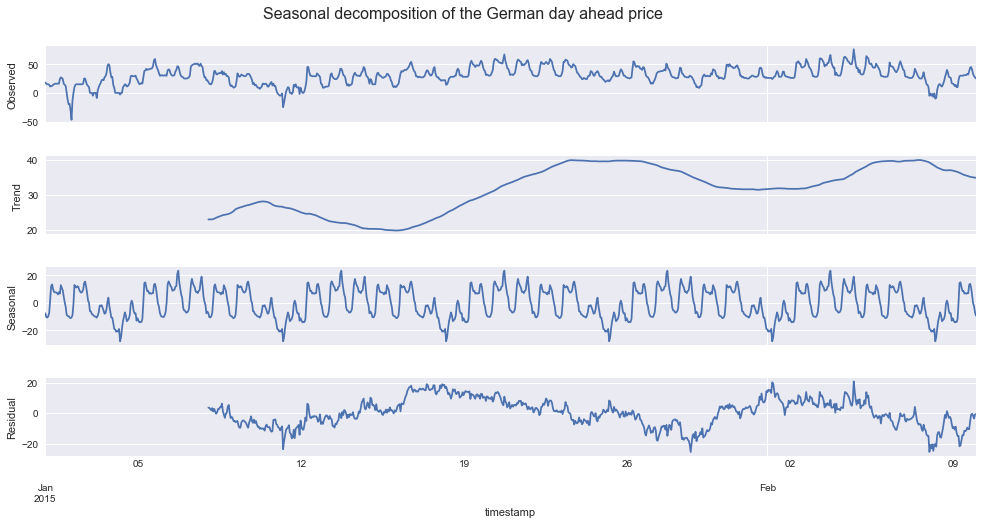

In [29]:
# have a look at the decomposition to visualise the conclusion that there is no information extracted from
# the obervations via the seasonal components (observations plot looks near identical to the final residual plot)
week_decomp = sm.tsa.seasonal_decompose(d2.DE_price_day_ahead.iloc[0:40*24],
                                        model='additive', freq=7*24, two_sided=False)

_ = week_decomp.plot()
_.set_figwidth(15)
_.set_figheight(8)
_ = _.suptitle("Seasonal decomposition of the German day ahead price", fontsize=16, y=1.03)

In [30]:
selected_variables = ['DE_price_day_ahead',               # target variable to predit
                      'DE_load_',                         # total load in Germany
                      'DE_solar_generation',              # German solar data
                      'DE_wind_generation',               # German wind data
                      'PL_load_', 'PL_wind_generation',   # Polish load an wind generation
                      'FR_load_', 'GB_load_',             # Load data from other countries  
                     ]

data = d2.loc[:, selected_variables]

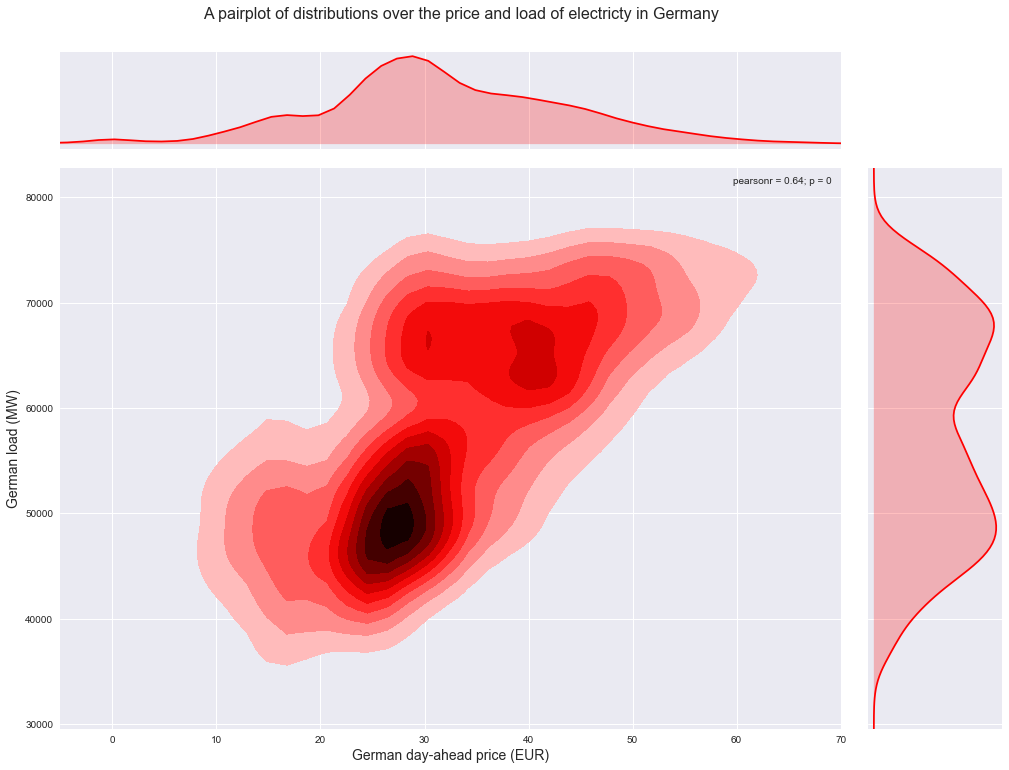

In [31]:
g = sns.jointplot(x='DE_price_day_ahead', y='DE_load_', data=data, kind="kde", color="r", size=12, xlim=[-5,70])
#g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".", alpha=0.1)
g.ax_joint.collections[0].set_alpha(0)
g.fig.suptitle("A pairplot of distributions over the price and load of electricty in Germany",
               fontsize=16, y=1.05, x = 0.45)
_ = g.set_axis_labels( "German day-ahead price (EUR)", "German load (MW)", fontsize=14)
g.fig.set_figwidth(14)
g.fig.set_figheight(10)

In [32]:
data.columns

Index(['DE_price_day_ahead', 'DE_load_', 'DE_solar_generation',
       'DE_wind_generation', 'PL_load_', 'PL_wind_generation', 'FR_load_',
       'GB_load_'],
      dtype='object')

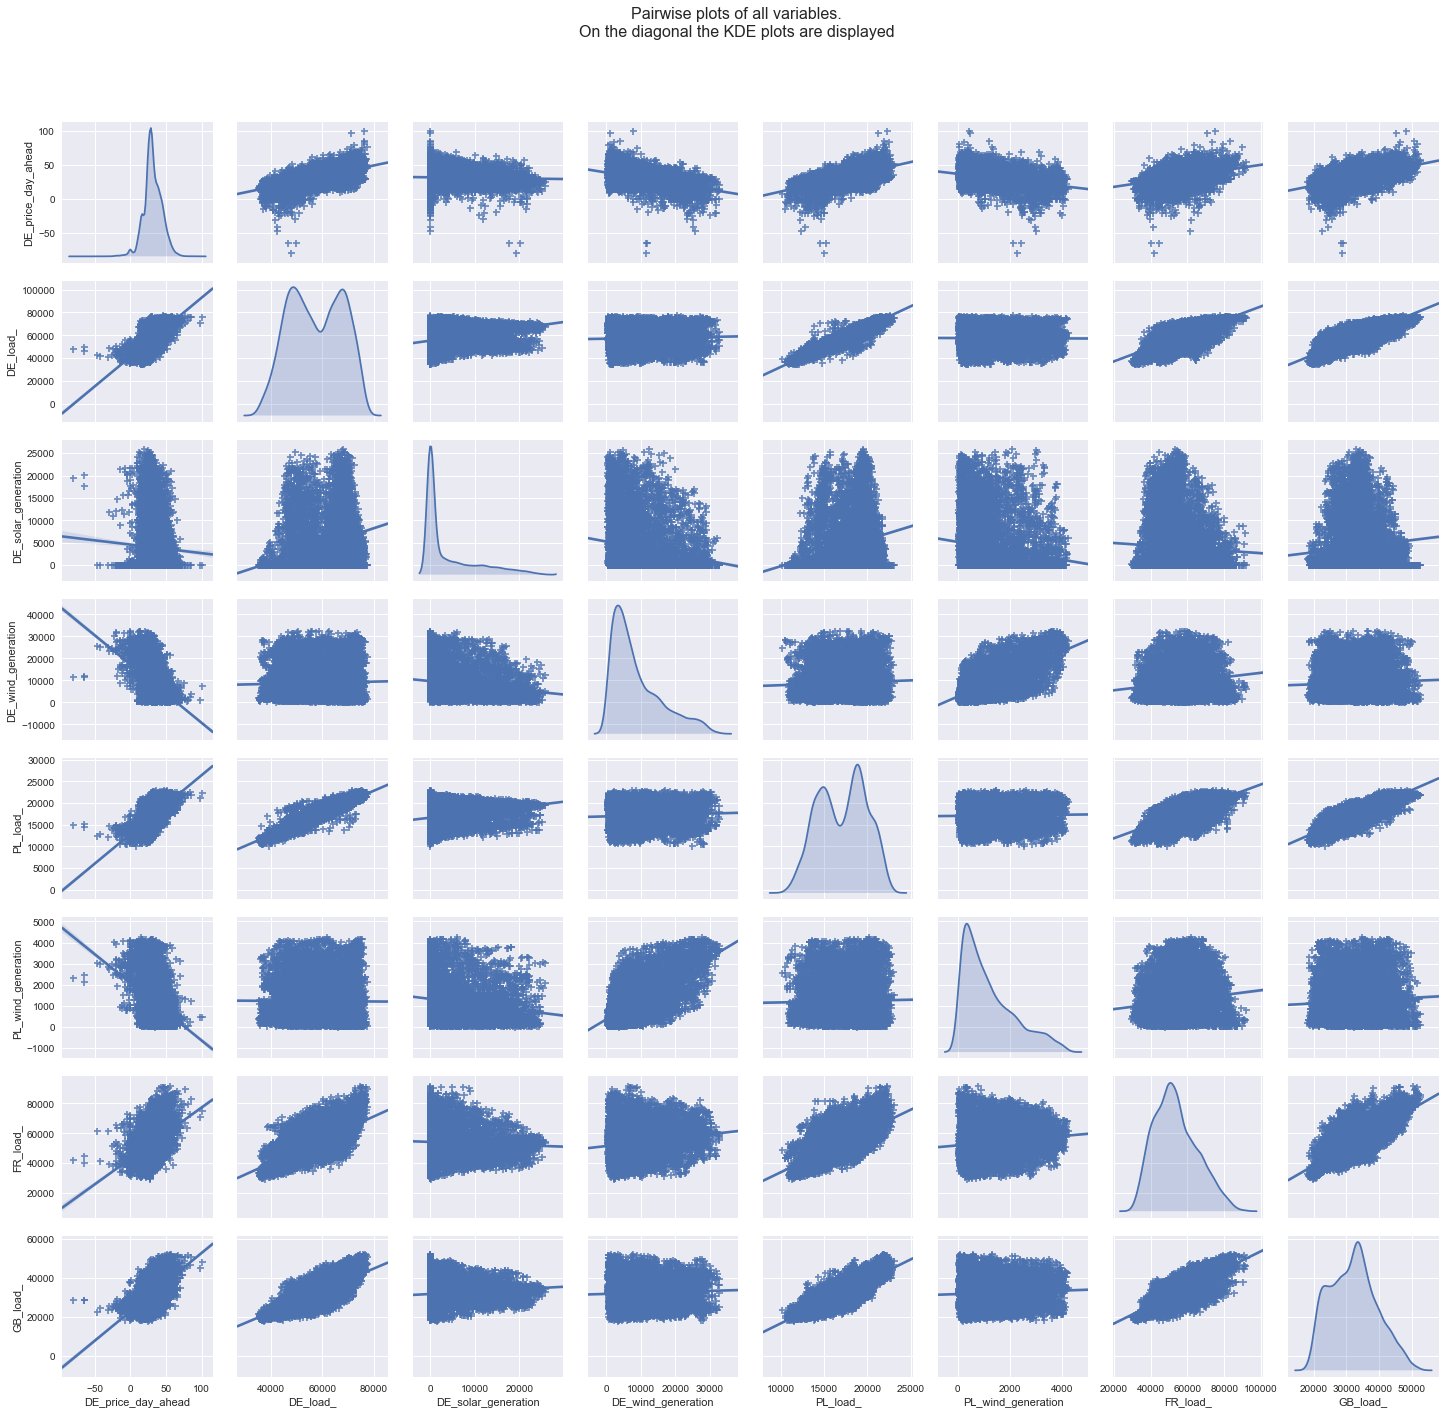

In [33]:
ax = sns.pairplot(data, kind='reg', diag_kind='kde', markers="+",
                  diag_kws={'shade': True})
plt.subplots_adjust(top=0.9)
_ = ax.fig.suptitle('Pairwise plots of all variables.\nOn the diagonal the KDE plots are displayed',
                    fontsize=16)

In [34]:
# Compute the the log differences of the values to remove any non-stationarity in the data set.
logdata = np.log(data).diff().fillna(value=0)[1:]

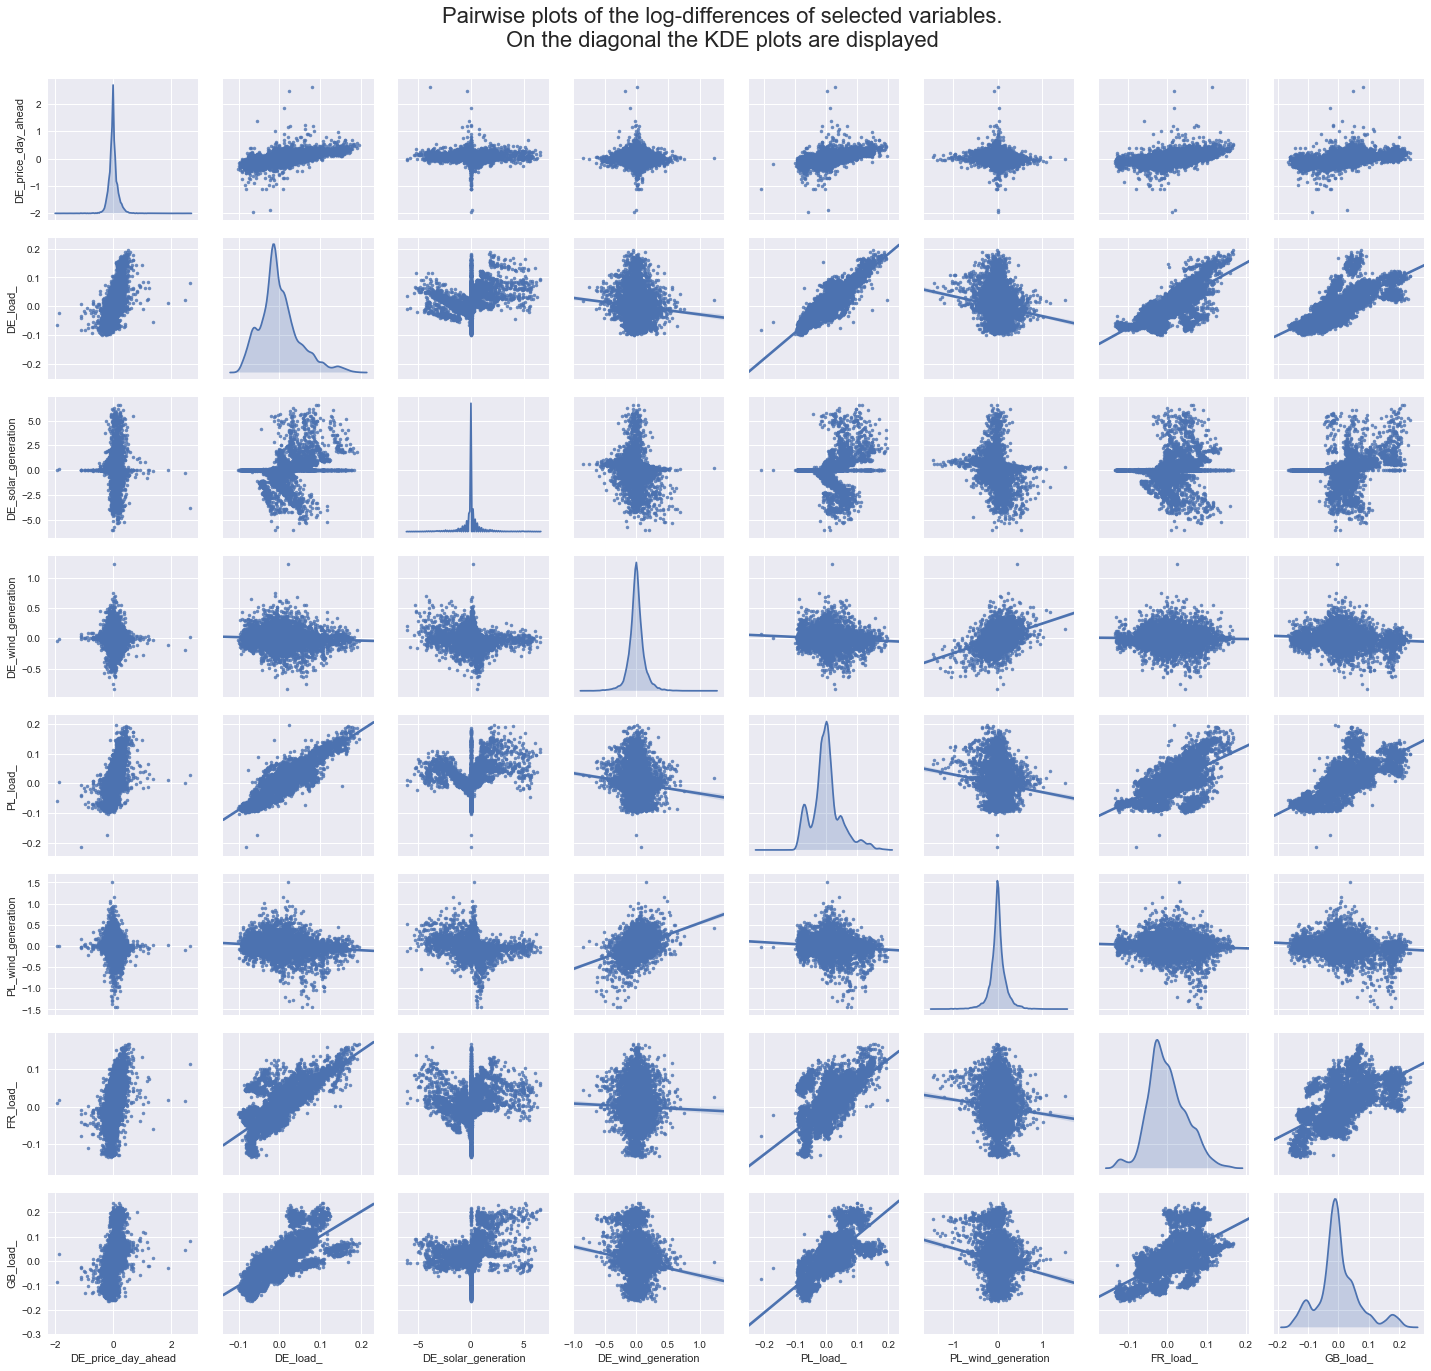

In [35]:
ax = sns.pairplot(logdata, kind='reg', diag_kind='kde', markers=".",
                  diag_kws={'shade': True})
plt.subplots_adjust(top=0.9)
_ = ax.fig.suptitle('Pairwise plots of the log-differences of selected variables.\nOn the diagonal the KDE plots are displayed',
                    fontsize=22, y=0.95)

###### Save the data predictive analytics in the next notebook

In [36]:
data.to_csv(open('modelling_input.awesome', 'w'))